[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. Loan Approval**
2. Breast Cancer Misclassification
3. **Recidivism Prediction** <== I got this one!

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 **Prosecution** <=== I got this one!
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [66]:
!pip install --upgrade ipython
import IPython.core

In [58]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np

if not hasattr(np, "obj2sctype"):
    np.obj2sctype = lambda obj, default=None: np.dtype(obj).type

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
import lime
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay

In [44]:

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees


In [46]:
# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [75]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]


In [53]:
print("Data Structure")
print("---------------")
print(f"Dimensions: {X_train.shape}")
print(f"Data Types:\n{X_train.dtypes}")
print(f"Missing Values:\n{X_train.isnull().sum()}")


Data Structure
---------------
Dimensions: (5771, 8)
Data Types:
age                int64
sex                 int8
race                int8
priors_count       int64
juv_fel_count      int64
juv_misd_count     int64
juv_other_count    int64
c_charge_degree     int8
dtype: object
Missing Values:
age                0
sex                0
race               0
priors_count       0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
c_charge_degree    0
dtype: int64


In [54]:
#For LIME and anchors, we need to define some characteristics
print(X_train['sex'].unique())
print(X_train['race'].unique())
print(X_train['c_charge_degree'].unique())

categorical_cols = ['sex', 'race', 'c_charge_degree']
categorical_features = [X_train.columns.get_loc(col) for col in categorical_cols]
print(categorical_features)
class_names = ['No', 'Yes']
categorical_names = {X_train.columns.get_loc(col): list(X_train[col].unique()) for col in categorical_cols}
print(categorical_names)


[1 0]
[2 0 5 3 1 4]
[0 1]
[1, 2, 7]
{1: [1, 0], 2: [2, 0, 5, 3, 1, 4], 7: [0, 1]}


### LIME

/Users/diya/Desktop/duke_files/aipi590_xai/repo/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


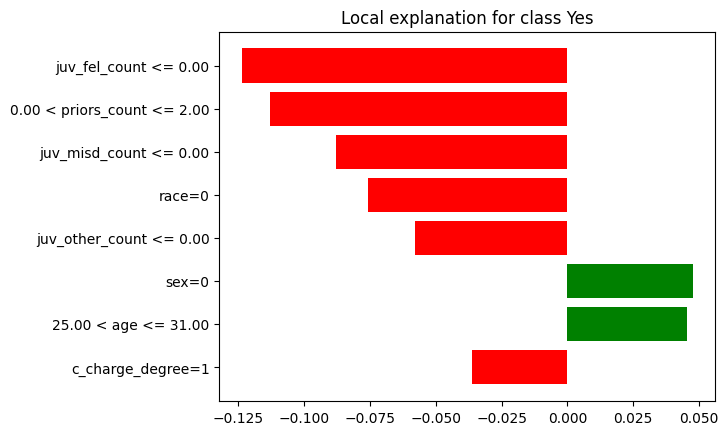

In [137]:
# Define kernel_width
kernel_width = 3


# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,class_names=class_names, feature_names=features,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names, kernel_width=kernel_width, mode='classification')
# Choose a sample for explanation
#idx = 0
# Explain the prediction using LIME
exp = explainer.explain_instance(focus_instance_compas.values[0], model_compas.predict_proba, num_features=8)
#exp = explainer.explain_instance(focus_instance_compas, model_compas.predict_proba, num_features=12)

# Show the explanation
exp.as_pyplot_figure()
exp.save_to_file("lime_exp.html")

![LIME explanation](lime_exp2.png)

In [141]:
print(focus_instance_compas)

   age  sex  race  priors_count  juv_fel_count  juv_misd_count  \
0   27    1     1             1              0               0   

   juv_other_count  c_charge_degree  
0                0                1  


#### Interpretation

In this LIME explaner, I used the given focus instance to show the explanation of the model's prediction. It shows the prediction probability for this instance was 90% confidence in the prediction class of No for recidivism of Malik Johnson. 

The bar plot in the middle shows the features that contributed to the prediction that caused the confidence in the No recidivism prediction (features on the left/blue) versus those that caused the confidence in the Yes recidivism prediction (features on the right/orange). The values for each bar are the coefficient weights for the linear model LIME created for the local explanation. So a higher weight shows a higher influence on the local prediction. 

As shown in the bar plot, the feature "juv_fel_count" when it is <= 0 had the strongest influence of predicting No for recidivism for this focus instance. The feature "c_charge_degree" when it is == 1 had the least influence of predicting No for the recisdivism for this focus instance. 

Based on the LIME bar plot explanation, a trait of this model that maybe does not relay to real life is the influence of the feature "c_charge_degree". Since c_charge_degree counts as a felony which is worse than a misdemeanor, I would think it would contribute to indfluencing a Yes prediction for recidivism. But "c_charge_degree" when == 1 contributes to No.

The table on the right shows the actual value for each feature for this particular instance and the feature is highlighted with its contribution to each of the binary outcomes.

There might be an error or inconsistency in the model because the feature value "race" for the instance is African-American which is associated with the numerical code 1. But in the right table it shows the true value for the "race" feature was 0 and was shown as True, which I believe is incorrect.  

### SHAP

In [142]:
# Compute SHAP values

X100 = shap.utils.sample(X_train, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(model_compas, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

 99%|===================| 2846/2886 [01:15<00:01]        

(1443, 8, 2) (1443, 8)


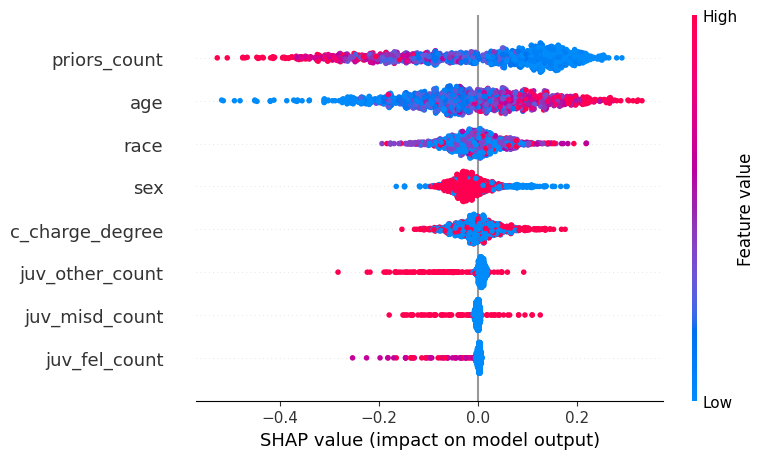

In [ ]:
# Visualize SHAP with Summary Plot
print(shap_values.shape, X_test.shape)
shap.summary_plot(shap_values[:, :, 0], X_test) #just the NO binary of the classes
plt.show()


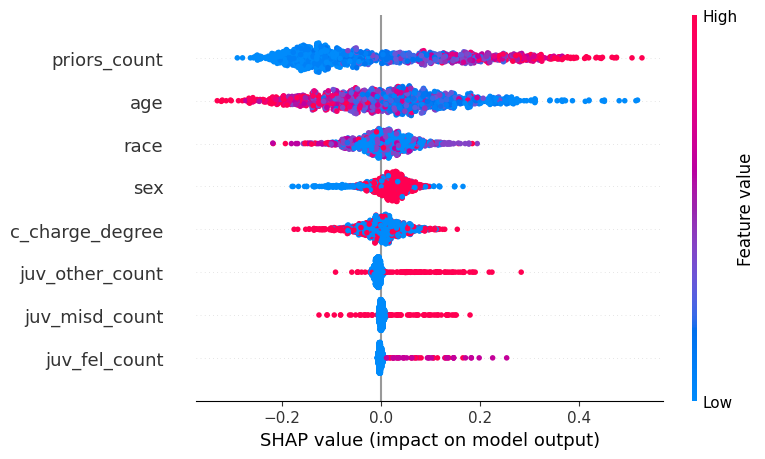

In [ ]:
# Visualize SHAP with Summary Plot
shap.summary_plot(shap_values[:, :, 1], X_test) #just the YES binary of the classes
plt.show()

#### Interpretation - SHAP Summary Plot

The SHAP summary plot has been shown for each of the binary classifiers. So the two summary plots are reflections of each other. I'll focus on the second summary plot which shows the impact of the features on the yes prediction for recidivism.

The y-xais shows the list of the features the model depends on. The x-axis shows the calculated SHAP values that dictate the influence of the feature on the model prediction. 

Each datapoint on this plot represents a sample's SHAP value for the corresponding feature.

A positive SHAP value represents if the feature positively impacts the model's prediction of yes, which will increase the yes prediction's probability.
A negative SHAP value represents if the feature negatively impacts the model's prediction of yes, which will decrease the yes prediction's probability (or increase the no prediction's probability).

The color of the datapoint relates to the actual value for the feature, where red is a higher feature value and blue is a lower feature value. For example, in terms of the feature "age", if a sample is of older age then the color would be more red and a sample of younger age would be more blue.

Based on the explained attributes above of the summary plots, we can see that a person with a higher "priors_count" (a point for the "priors_count" feature that is more red) would be more likely in classifying as yes for recidivism because the more red points for the feature are associated with more positive SHAP values (more on the right side of the plot). In this way, we can say that people of less priors count will be less likely to recidivate.

Since categorical features like "race" have been transformed into numerical values, it is difficult to understand what a higher/lower feature value means in this plot.


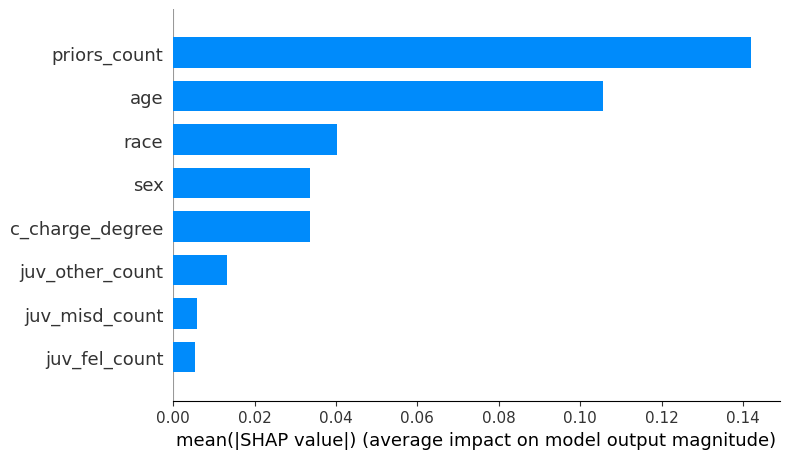

In [153]:

shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")


#### Interpretation - SHAP Bar chart

This bar plot shows the magnitude of each feature's influence on the model's prediction. However, it does not show directionality of the influence (increasing or decreasing the yes output's probability).

This way we can compare the impact of features against each other.

As shown on the bar plot, the feature "priors_count" has the highest influence on the model's prediction and "juv_fel_count" has the least influence on the model's prediction. 

It seems weird to me that the "juv_other_count", "juv_misd_count", and "juv_fel_count" have less influence on the prediction than race, sex, and age because a similar feature "priors_count" has such a high impact (higher than race, age, and sex).

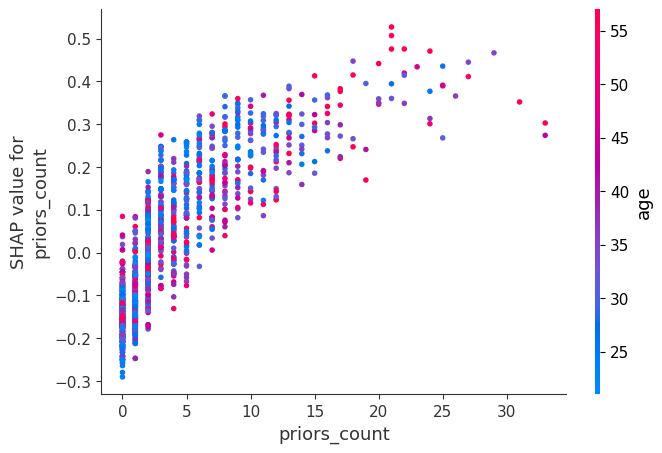

In [161]:

# Visualize SHAP with Dependence Plot
shap.dependence_plot('priors_count', shap_values[:, :, 1], X_test)


#### Interpretation - SHAP Dependence Plot

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. 

For this dependence plot, I chose the feature value "priors_count", which has the highest impact on the model's prediction as found above. As shown on the plot, as the "priors_count" feature value increases, the SHAP value increases from a negative SHAP value to a positive SHAP value. A higher SHAP value means that it has a positive impact on the model's yes prediction for recidivism. So a higher priors count increase the model's probability of predicting yes for recidivism.

The color of each datapoint is associated with the feature "age", where a older person's sample is more red and a younger person's sample is more blue. In this plot, there is no obvious correlation between "age" and "priors_count". For example, it does not obviously show that a higher prior count is also associated with a older person.

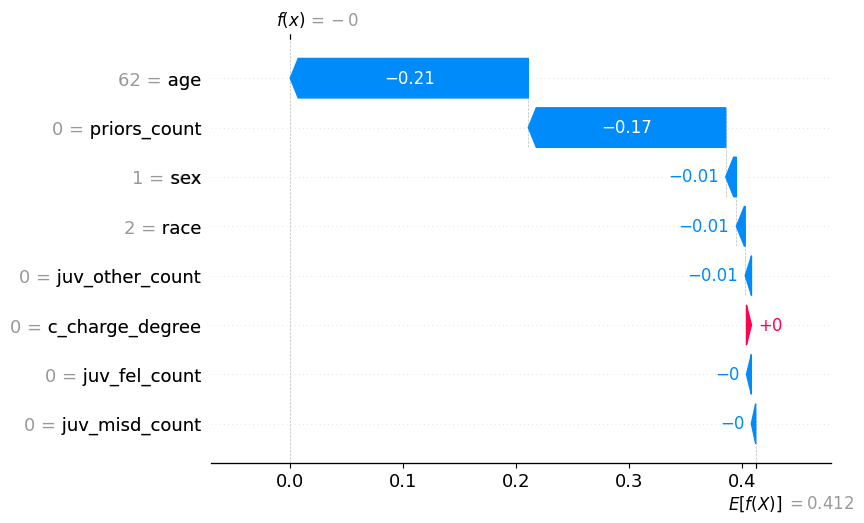

In [164]:

# Visualize an instance with a waterfall plot of the SHAP values
# Choose a sample for explanation
idx = 0

# Plot waterfall plot
shap.plots.waterfall(shap_values_exp[:, :, 1][idx])

#### Interpretation - SHAP Waterfall Plot

You can visualize the SHAP values for an instance of interest. For an instance of interest, you can see the SHAP values and their contribution to the prediction for that instance.

On the left side of the feature names are the specific feature values for the instance of interest.

For this specific instance, it is shown that the feature value for "age" decreased the model's yes prediction the most. The specific feature value for "age" for this instance was 62 years old. So, this is also shown by the SHAP summary plot that displayed that a older person is less likely to recidivate (decrease the prediction's yes probability of recidivating).

I find there is an error, where there is a +0 and -0 for "c_charge_degree" and "jv_fel_count" because 0 cannot be positive or negative.
